In [ ]:
%%html
<script>
$("div.input").hide();
code_show=true; 
function code_toggle() {
 if (code_show){
   $("div.input:not(:first)").hide();
   $("div.prompt").hide();
 } else {
   $("div.input:not(:first)").show();
   $("div.prompt").show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
    .sidebar-wrapper {
        border-style: none
    }
    
    /* Pretty Pandas Dataframes */
    .dataframe * {border-color: #ffffff !important;}
    .dataframe td {
        text-align: right; 
        min-width:5em;
    }
    .dataframe tbody tr:nth-child(odd) {
        background: #f5f5f5;
    }
</style>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/show code."></form>

# NIPS impementation challenge: "Concentration of Multilinear Functions of the Ising Model with Applications to Network Data"

This notebook provides some example code to implement the algorithm mentioned in [<a href="">Daskalakis et al. 2017</a>] for testing the hypothesis that a synthetic sample generated via some process which causes it to be different from an Ising model in the high temperature regime  could have been sampled from an Ising model in the high temperature regime. This departure of the generated lattice from the high-temperature limit of the Ising model is parameterized by some number $\tau \in [0, 1]$ and here the results in [<a href="">Daskalakis et al. 2017</a>] are confirmed for the values of $\tau$ where the statistic used can detect this departure.

In [1]:
import itertools

import random

import numpy as np
import scipy as sp

import seaborn as sns
sns.set()

%matplotlib inline

## Construct samples

### Social network

Our departures from the null hypothesis are generated in the following manner, parameterized by some parameter $\tau \in [0, 1]$. The grid is initialized by setting each node independently to be $-1$ or $1$ with equal probability. We then iterate over the nodes in column major order. For the node $\sigma_{v_x}$ at position $v_x = (i, j)$, we select a node $\sigma_{v_y}$ at one of the following positions uniformly at random: $v_1 = (i, j + 1),\; v_2 = (i, j + 2),\; v_3 = (i + 1, j + 1),\; v_4 = (i + 1, j),\; v_5 = (i + 2,j),\; v_6 = (i + 1, j-1)$.

$$\begin{pmatrix}
&&&&&&\\
&&\sigma_{i, j}&\sigma_{i, j+1}&\sigma_{i, j + 2}&&\\
&\sigma_{i + 1, j - 1}&\sigma_{i + 1, j}&\sigma_{i + 1, j + 1}&&&\\
&&\sigma_{i + 2, j}&&&&\\
&&&&&&
\end{pmatrix}$$



Then, with probability $\tau$, we set $\sigma_{v_y}$ to have the same value as $\sigma_{v_x}$. We imagine this construction as a type of social network model, where each individual tries to convert one of his nearby connections in the network to match his signal, and is successful with probability $\tau$.


In [2]:
# Constants
theta_critical = np.log(1 + np.sqrt(2)) / 2
print "Critical value of theta:", theta_critical

Critical value of theta: 0.44068679351


In [17]:
def get_neighbors(u, N, distance=1):
    """List all neighbors for a given vertex u = (row, col) on an NxN lattice."""
    row, col = u[0], u[1]
    neighbors = [((row - distance + i) % N, (col - distance + j) % N)
                 for (i, j) in np.ndindex(2 * distance + 1, 2 * distance + 1)
                 if sp.spatial.distance.cityblock((i, j), (distance, distance)) <= distance]
    neighbors.remove(u)
    return neighbors


def stochastic_social_network(n_rows, n_cols, tau):
    """Construct an n_rows x n_cols grid of up and down spins.

    :param int n_rows: number of rows
    :param int n_cols: number of columns
    :param float tau: number between 0 and 1 that parameterizes the distance
        from a perfectly random grid by introducing correlations between nearby
        spins. In particular, it is the probability that a given spin can
        'convince' one of its 'friends' (Manhattan distance 2 or less) to copy
        its value
    """
    social_grid = (np.random.choice([1, -1], size=n_rows * n_cols)
                   .reshape(n_rows, n_cols))
    # iterate over index of vertices in column major order
    for col, row in np.ndindex(n_cols, n_rows):
        # list nearby vertices that are:
        # - at Manhattan distance 2 or less from v_x
        # - to the right or below v_x (using periodic boundary conditions)
        v_1 = (row, ((col + 1) % n_cols))
        v_2 = (row, ((col + 2) % n_cols))
        v_3 = ((row + 1) % n_rows, ((col + 1) % n_cols))
        v_4 = (((row + 1) % n_rows), col)
        v_5 = (((row + 2) % n_rows), col)
        v_6 = (((row + 1) % n_rows), ((col - 1) % n_cols))
        # pick uniformly at random from [v_1, ..., v_6]
        v_y = random.choice([v_1, v_2, v_3, v_4, v_5, v_6])

        # Pick a number between 0 and 1 with p(1) = tau
        convinced = np.random.choice([True, False], p=[tau, 1-tau])
        if convinced:
            social_grid[v_y] = social_grid[(row, col)]

    return social_grid


class Ising_lattice(object):
    """Constructs NxN Ising lattice with nearest-neighbor interaction theta."""
    
    def __init__(self, N, theta):
        self.N = N
        self.theta = theta
        self.mixing_time = self._mixing_time()
        self.glauber_transition_probabilities = self._compute_glauber_transition_probabilities()
        # Create an Ising state by running Glauber dynamics until mixing occurs
        self.random_lattice = self.random_ising_lattice()
        self.ising_lattice = self.ising_lattice()
    
    def _compute_glauber_transition_probabilities(self):
        return {delta: 1. / (1 + np.exp(self.theta * delta))
                for delta in (-8, -4, 0, 4, 8)}
    
    def _mixing_time(self):
        """Estimate mixing time for eta-high-temperature regime."""
        n_nodes = self.N ** 2
        eta = 1 - np.tanh(self.theta)
        mixing_time = int(n_nodes * np.log(n_nodes) / eta)
        return mixing_time
            
    def glauber_step(self, lattice):
        """Perform one step in Glauber dynamics."""
        # Choose a random spin i indexed by (row_i, col_i)
        row_i, col_i = np.random.randint(0, self.N), np.random.randint(0, self.N)
        # Find its nearest neighbours (under pbc) and compute energy delta
        sum_of_neighboring_spins = sum(
            [lattice[v] for v in get_neighbors((row_i, col_i), self.N, 1)])
        delta = 2 * lattice[(row_i, col_i)] * sum_of_neighboring_spins
        # Look up transition probability p_flip
        p_flip = self.glauber_transition_probabilities[delta]
        # With probability p_flip, flip spin i
        random_number = np.random.uniform()
        if random_number < p_flip:
            lattice[row_i, col_i] *= -1
        return lattice

    def random_ising_lattice(self):
        return (np.random.choice([1, -1], size=self.N ** 2)
                .reshape(self.N, self.N))

    def ising_lattice(self):
        """Run the Glauber dynamics long enough to reach mixing."""
        # initialize lattice at random
        lattice = self.random_lattice
        
        for _ in range(self.mixing_time):
            lattice = self.glauber_step(lattice)
        
        return lattice
    
    def sample_ising_states(self, n_samples):
        """Starting from an Ising state, create a collection of n_samples."""
        intermediate_state = self.ising_lattice
        samples = []
        
        for _ in range(n_samples):
            intermediate_state = glauber_step(intermediate_state)
            samples.append(intermediate_state)
        
        return samples

In [4]:
def L(theta, lattice):
    spin_array = lattice.flatten()
    N = len(spin_array)
    return (float(theta) / N) * (
        spin_array[1] * (spin_array[0] - np.tanh(theta * spin_array[1])) +
        spin_array[N - 2] * (spin_array[N - 1] - np.tanh(theta * spin_array[N - 2])) +
        sum([(spin_array[i - 1] + spin_array[i + 1]) * (spin_array[i] - np.tanh(
            theta * (spin_array[i - 1] + spin_array[i + 1]))) for i in range(1, N - 1)])
    )


def maximum_partial_likelihood_estimator(lattice):
    """MPLE for theta under the assumption of a nearest-neighbours Ising model."""
    return sp.optimize.fsolve(L, 0.5, args=(lattice))[0]


def local_partition_function(lattice, N, external_field=0, distance=2):
    """Compute the local partition function for a lattice."""
    offset = np.tanh(external_field)
    return sum([(lattice[u] - offset) * sum([
            (lattice[v] - offset) for v in get_neighbors(u, N, distance=distance)])
                    for u in np.ndindex(N, N)])


def hypothesis_test_high_temp_ising(lattice, number_ising_samples=100):
    """Perform a hypothesis test on a square test lattice."""
    reject_null_hypothesis = 0
    theta_mple = maximum_partial_likelihood_estimator(lattice)
    if theta_mple > theta_critical:
        reject_null_hypothesis, reason_code = 1, "mple"
        return reject_null_hypothesis, reason_code
    N = int(np.sqrt(len(lattice)))  # assume lattice is square and written as flat array
    sampled_values_statistic = sorted([local_partition_function(
        Ising_lattice(N, theta=theta_mple).ising_lattice, N, distance=2) for _ in range(number_ising_samples)])
    test_lattice_statistic = local_partition_function(lattice, N, distance=2)
    if (test_lattice_statistic < sampled_values_statistic[int(0.025 * number_ising_samples)] or
        test_lattice_statistic > sampled_values_statistic[int(0.975 * number_ising_samples)]):
        reject_null_hypothesis, reason_code = 1, "p-value"
        return reject_null_hypothesis, reason_code
    else:
        return reject_null_hypothesis, "fail"
    

In [27]:
# Tests
def magnetization(lattice):
    return lattice.flatten().sum()

def energy(lattice):
    N = len(lattice)
    return sum([-0.5 * lattice[row, col] * sum(
        [lattice[v] for v in get_neighbors((row, col), N, 1)])
            for (row, col) in np.ndindex(N, N)])

def test_mple_ising():
    # Construct Ising grid with pre-determined value of theta
    # under the assumption that there is no external field
    # theta = 0 corresponds to the high-temperature limit of
    # the Ising model under 0 external field. In this case, the
    # model is random.
    epsilon = 5e-2
    random_grid = random_array(40 ** 2)
    print maximum_partial_likelihood_estimator(random_grid)
    assert maximum_partial_likelihood_estimator(random_grid) < epsilon

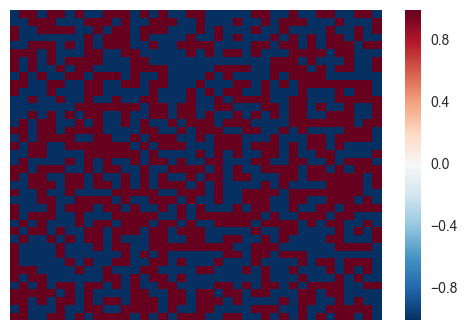

In [5]:
n_rows, n_cols, tau = 40, 40, 0
social_grid = stochastic_social_network(n_rows, n_cols, tau)
sns.heatmap(social_grid, xticklabels=False, yticklabels=False);

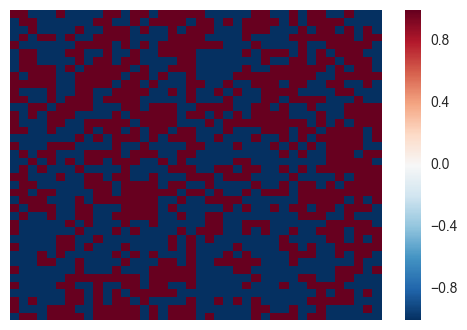

In [6]:
n_rows, n_cols, tau = 40, 40, 1
social_grid = stochastic_social_network(n_rows, n_cols, tau)
sns.heatmap(social_grid, xticklabels=False, yticklabels=False, cbar=True);

### Ising model


The data will be compared with an Ising model, of which we give an example state below with nearest-neighbour interaction $\theta = 0.1$). It is clearly difficult to tell these states apartjust by looking at them.

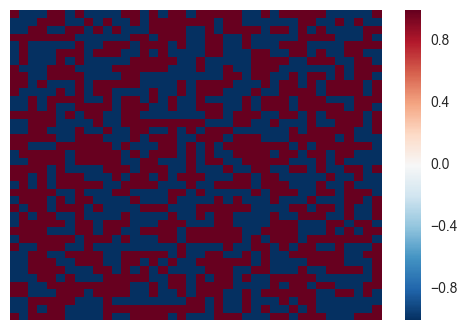

In [19]:
ising = Ising_lattice(40, 0.1)
sns.heatmap(ising.ising_lattice, xticklabels=False, yticklabels=False, cbar=True);

We can check whether our MCMC algorithm is correctly implemented by computing the magnetization and energy for each step of the Glauber dynamics and ascertaining that the magnetization remains close to 0 and the energy decreases on average.

In [28]:
lattice = ising.random_lattice
energies, magnetizations = [], []
for _ in range(1000):
    energies.append(energy(lattice))
    magnetizations.append(magnetization(lattice))
    lattice = ising.glauber_step(lattice)

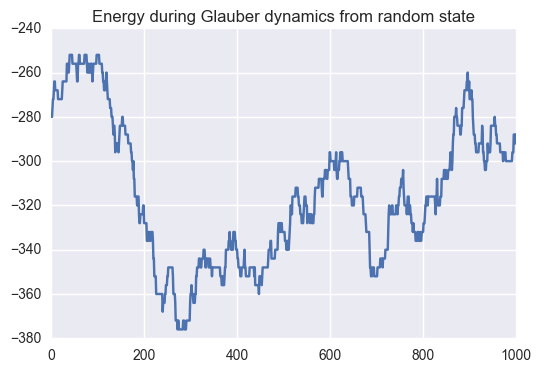

In [31]:
sns.plt.plot(energies);
sns.plt.title("Energy during Glauber dynamics from random state");

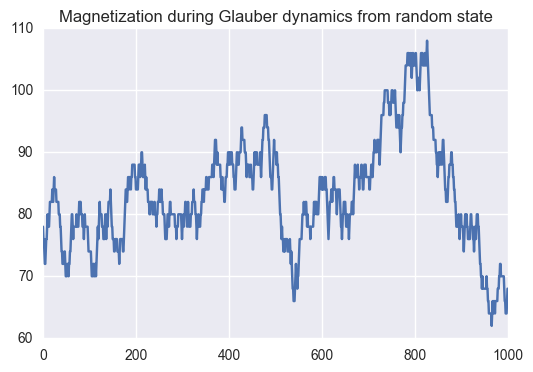

In [32]:
sns.plt.plot(magnetizations);
sns.plt.title("Magnetization during Glauber dynamics from random state");

## Hypothesis testing

Given the Ising model on a graph $G = (V, E)$,
$$p(\sigma)=\exp\left(\theta_v\sigma_v + \theta_{u,v}\sigma_u\sigma_v - F({\beta})\right),$$
where $\sigma$ is one state, and $\theta_v$ and $\theta_{u, v}$ a local magnetic field and magnetic interaction terms, respectively, and $F(\beta)$ proportional to the free energy.

Our null hypothesis is that the sample is generated from an Ising model in the high temperature regime on the grid, with no external field (i.e. $\theta_u = 0$ for all $u$) and a constant neares-neighbour interaction strength parameterized by $\theta$ (i.e., $\theta_{uv}=\theta$ iff nodes $u$ and $v$ are adjacent in the grid, and $0$ otherwise). For the Ising model on the grid, the critical edge parameter for high-temperature is
$\theta_c=\ln(1+\sqrt{2})/2$. In other words, we are in high-temperature if and only if $\theta\leq \theta_c$, and we can reject the null hypothesis if the MPLE estimate $\hat{\theta} > \theta_c$.

### Estimate Ising model parameters

Given a single multivariate sample, we first run the maximum pseudo-likelihood estimator (MPLE) to obtain an estimate of the model’s parameters under the null hypothesis that the sample is generated by a high-temperature Ising model.

The pseudo-likelihood is an approximation of the likelihood, where instead of the entire partition function, one needs to compute only a local partition function (is it a mean field approximation?).

Given a random vector $\sigma=(\sigma_1, \sigma_2, \ldots , \sigma_N)$ whose joint distribution is parametrized by a parameter $\theta \in \mathbb{R}$, the MPLE of $\theta$ is defined as
$$\hat{\beta}_N := \mbox{arg}\,\mbox{max}\prod_{i=1}^{N} f_i(\beta, \sigma),$$
where $f_i(\theta, \sigma)$ is the conditional probability density of $\sigma_i$ given $(\sigma_j)_{j\neq i}$.

For the case of the Ising model, this can be explicitly solved by computing the derivative with respect to $\theta$
$$L_{\sigma}(\theta) := \frac{1}{N}\sum_{i=1}^{N}m_i(\sigma)(\sigma_i - \tanh(\theta\, m_i(\sigma))),$$
with
$$m_i(\sigma) := \sum_{j=1}^{N}J_N(i, j)\,\sigma_j$$
for some $\sigma \in S_N:=\{−1, 1\}^N$ and an $N\times N$ symmetric matrix $J_N$ with zeros on the diagonals, indicating the interactions between spins on different sites.

Note that $m_i(\sigma)$ does not depend on $\sigma_i$ since the diagonal element $J_N(i,i)=0$. Interpreting $\tanh(\pm\infty) = \pm 1$, the function $L_\sigma$ can be extended to $[0,\infty]$ by defining
$L_{\sigma}(\infty):= \frac{1}{N}\sum_{i=1}^{N}\left(m_i(\sigma)\sigma_i-|m_i(\sigma)|\right)$. Then it is easy to verify (see <a href="https://mathscinet.ams.org/mathscinet-getitem?mr=2363958">Chatterjee</a>) that $\frac{1}{N}\frac{\partial}{\partial\theta}\log f_i(\theta, \sigma) = L_{\sigma}(\theta)$, and the function $L_{\sigma}(\theta)$ is a decreasing function of $\theta$. Therefore, the MPLE for $\theta$ in the Ising model is
$$\hat{\theta}_N (\sigma) := \inf\{ x \geq 0 : L_{\sigma}(x) = 0 \}.$$

In our case, our null hypothesis is that the data is generated by a nearest-neighbour Ising model with constant interaction and zero external field, in the high temperature regime.

Nearest neigbour interactions means that the matrix $J_N(i,j)$ has values $1$ on the elements with $|i-j|=1$ and zeros everywhere else, $J_N(i, j) = \delta_{|i-j|, 0}$:
$$J_N = \begin{pmatrix}
0 & \theta & 0 & 0 & \cdots & 0\\
\theta & 0 & \theta & 0 & \cdots & 0\\
0 & \theta & 0 & \theta &  & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots &\\
0 & \cdots & 0 &\theta & 0 & \theta \\
0 & \cdots & 0 &0&\theta & 0
\end{pmatrix}.$$
This greatly simplifies the equations:
$$m_i(\sigma) = \left\{
\begin{array}{cc}
\theta\sigma_2 & i=1\\
\theta\sigma_{N-1} & i=N\\
\theta(\sigma_{i-1}+\sigma_{i+1}) & 1 < i < N
\end{array}
\right.$$
So we have
$$
L_{\sigma}(\theta) = \frac{\theta}{N}\left(
\sigma_2\left(\sigma_1-\tanh(\theta\sigma_2)\right) + \sigma_{N-1}\left(\sigma_N - \tanh(\theta\sigma_{N-1})\right) + \sum_{i=2}^{N-1}\left(\sigma_{i-1}+\sigma_{i+1})(\sigma_{i} - \tanh(\theta(\sigma_{i-1} + \sigma_{i+1}))\right)
\right)
$$

In [8]:
n_rows, n_cols, tau = 40, 40, 1
social_grid = stochastic_social_network(n_rows, n_cols, tau)
theta_mple = maximum_partial_likelihood_estimator(social_grid)
print "MPLE estimate of theta:", theta_mple
print "High-temperature regime:", theta_mple <= theta_critical

MPLE estimate of theta: 0.10721771603
High-temperature regime: True


### MCMC using MPLE parameters
If the value of $\hat{\theta}$ is lower than the critical value, i.e. we cannot reject the null hypothesis on the grounds of it not being in the high temperature regime, we instead compute a statistic and compare its value of the sample to a range of values computed on a sample of high-temperature Ising models with the estimated nearest-neighbour interaction $\hat{\theta}$.
We use the local partition function as a statistic:
$$Z_{\mbox{local}} =  \sum_{u=(i,j)} \sum_{v=(k,l): d(u,v)\leq 2} X_uX_v,$$
with $d(u, v)$ the Manhattan distance between two lattice sites $u$ and $v$.

The statistic $Z_{\mbox{local}}$ is bilinear in the Ising model, which means it is better able to reject the null hypothesis, since its distribution for the Ising model will be very concentrated. In order to sample from the Ising distribution in the high temperature limit, we start with a random lattice and run the Glauber algorithm, which computes the transition probability of one state to another $\sigma_i\rightarrow \sigma_j$ as:
$$P(\sigma_i \rightarrow \sigma_j) = \frac{1}{1 + e^{\theta\Delta E_{ji}}}.$$
In the high temperature regime, mixing occurs quickly, and one needs to run these steps only $O(n\log n)$ times.

Finally, given the range of values for the statistic determined by MCMC, we reject the null hypothesis if p ≤ 0.05.

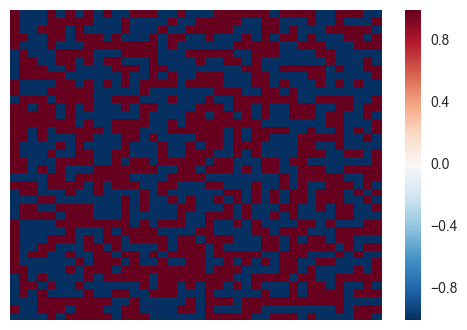

In [9]:
ising_mple = Ising_lattice(N=40, theta=theta_mple)

sns.heatmap(
    ising_mple.ising_lattice,
    xticklabels=False, yticklabels=False, cbar=True);

DescribeResult(nobs=100, minmax=(384.0, 1488.0), mean=927.67999999999995, variance=46865.997575757567, skewness=-0.13557720207962207, kurtosis=-0.12986905695149353)


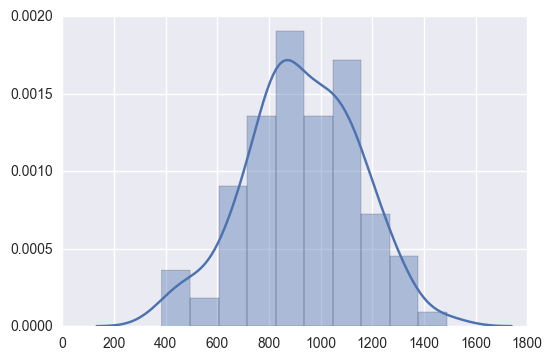

In [10]:
N = 40
sampled_values_statistic = sorted([local_partition_function(
    Ising_lattice(N, theta=theta_mple).ising_lattice, N, distance=2) for _ in range(100)])

print sp.stats.describe(sampled_values_statistic)
sns.distplot(sampled_values_statistic);

Compare this to the value of the local partition function for our social network lattice

In [11]:
statistic_social_grid = local_partition_function(social_grid, N, distance=2)
reject_null = ((statistic_social_grid > sampled_values_statistic[95]) or
               (statistic_social_grid < sampled_values_statistic[5]))
print "Reject null hypothesis (used cutoff p = 0.05, Z_2=%.1f)!" % statistic_social_grid \
    if reject_null else "Failed to reject null hypothesis."

Reject null hypothesis (used cutoff p = 0.05, Z_2=2192.0)!


So it looks like the case $\tau = 1$ is quite easy to distinguish from an Ising grid.

### Plot probability of rejecting null hypothesis vs tau

In order to test the power of this statistic in rejecting the null hypothesis for cases when the departure from high temperature Ising is less pronounced, we plot the probability of rejecting vs $\tau$.

In [ ]:
# 1. Construct network sample with value of tau
# 2. Get theta_mple
# 3. Check if theta_mple > theta_critical
#    -> return "Reject null hypothesis: theta_mple > theta_critical" if (theta_mple > theta_critical)
# 4. Generate 100 Ising samples with theta_mple
# 5. Compute local partition function for network sample
# 6. Compute local partition function for 100 Ising samples
# 7. Compute p-value
#    -> return "Reject null hypothesis: p < 0.05" if p < 0.05 else "Do not reject null hypothesis"


 tau: 0.0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 tau: 0.1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 tau: 0.2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

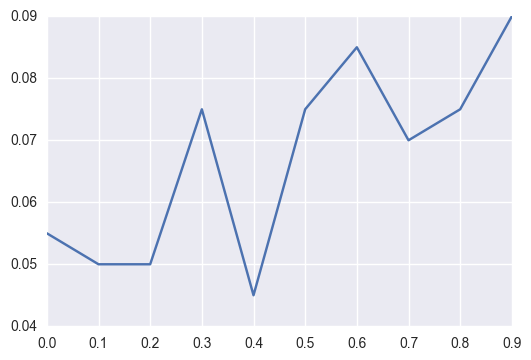

In [13]:
outcome_data = []
for tau in np.arange(0, 1, 0.1):
    print "\n tau:", tau,
    reasons, test_outcomes = [], []
    for _ in range(200):
        print ".",
        social_grid = stochastic_social_network(n_rows, n_cols, tau)
        reject_null, reason = hypothesis_test_high_temp_ising(social_grid)
        test_outcomes.append(reject_null)
        reasons.append(reason)
    outcome_data.append(
        {'tau': tau,
         'reject_null_avg': np.mean(test_outcomes),
         'reasons': reasons})

sns.plt.plot([data['tau'] for data in outcome_data],
             [data["reject_null_avg"] for data in outcome_data]);